# Loading data

In [1]:
import copy
import multiprocessing as mp
import random

import hicstraw
import juicebox_notebook
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import adjusted_rand_score

In [2]:
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])


# helper function for plotting
def plot_hic_map(
    dense_matrix: np.array,
    maxcolor: float,
    tads: list[list[int]] | None = None,
    ax=None,
    *,
    edgecolor: str = "g",
    label: str = None
):
    # TAD communities and matrix must be on the same resolution, otherwise it wont work
    ax = plt.gca() if ax is None else ax
    ax.matshow(dense_matrix, cmap=REDMAP, vmin=0, vmax=maxcolor)
    if tads:
        for i, tad in enumerate(tads):
            rect = patches.Rectangle(
                (tad[0], tad[0]),
                len(tad),
                len(tad),
                linewidth=1,
                edgecolor=edgecolor,
                label=label if i == 0 else None,
                facecolor="none",
            )
            ax.add_patch(rect)


def plot_hic_map_compare(
    dense_matrix: np.array,
    maxcolor: float,
    tads: list[list[list[int]]],
    titles: list[str] | None = None,
):
    assert titles is None or isinstance(titles, list)
    assert titles is None or len(tads) == len(titles)

    fig, axs = plt.subplots(1, len(tads), figsize=(len(tads) * 6, 5))

    for i, (tad, ax) in enumerate(zip(tads, axs)):
        plot_hic_map(dense_matrix, maxcolor, tads=tad, ax=ax)
        if titles:
            ax.set_title(titles[i])


def plot_hic_map_compare_single(
    dense_matrix: np.array,
    maxcolor: float,
    tads: list[list[list[int]]],
    labels: list[str] | None = None,
    colors: list[str] | None = None,
):
    assert labels is None or isinstance(labels, list)
    assert colors is None or isinstance(colors, list)
    assert labels is None or len(tads) == len(labels)
    assert colors is None or len(tads) == len(colors)

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    for i, tad in enumerate(tads):
        color = colors[i] if colors else None
        label = labels[i] if labels else None
        plot_hic_map(dense_matrix, maxcolor, tad, ax, edgecolor=color, label=label)
    plt.legend()

In [3]:
juicebox_notebook.init()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
b = juicebox_notebook.Browser(
    {  # load hic via URL
        "name": "GM12878",
        # "locus": "2:3,319,567-30,009,566",
        "url": "https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic",
        "normalization": "KR",
    }
)

<IPython.core.display.Javascript object>

# Arrowhead

In [5]:
# java -jar juicer_tools_1.22.01.jar arrowhead <options, eg: > -k NONE -r 5000 hic_data/inter_30.hic test --ignore-sparsity

## Links

[Main juicer repo (git clone)](https://github.com/aidenlab/juicer)   
[Arrowhead jar download](https://github.com/aidenlab/juicer/wiki/Download)   
[Arrowhead use instruction](https://github.com/aidenlab/juicer/wiki/Arrowhead)  

# Algorithm

In [6]:
class ModLouvain:
    def __init__(self, A, gamma, N=100, eps=1e-10, seed=None):
        self.A = A
        self.gamma = gamma
        self.N = N  # number of times to run the algorithm
        self.classes = list(
            range(len(A))
        )  # communities assignments, at first -- each node to different community
        self.eps = eps  # for stopping condition

        if seed:
            random.seed(seed)

    def run(self, verbose=False):
        # main function to use "outside" -- algorithm is run N times, and then aggregated -- https://www.biorxiv.org/content/10.1101/089011v1.full
        # remade with multiprocessing
        self.N_communities = []
        self.N_communities_indexes = []
        pool = mp.Pool()
        for i in range(self.N):
            if verbose:
                print(f"Algorithm run {i+1}...")
            pool.apply_async(
                self._run_algorithm, args=(verbose,), callback=self.append_communities
            )
        pool.close()
        pool.join()
        best_index = self.aggregate_results(self.N_communities_indexes)
        return self.N_communities[best_index]

    def append_communities(self, result):
        self.N_communities.append(result[0])
        self.N_communities_indexes.append(result[1])

    def aggregate_results(self, communities):
        num_comm = len(communities)
        pairwise_rand = np.zeros((num_comm, num_comm))

        for i in range(num_comm):
            for j in range(num_comm):
                pairwise_rand[i, j] = adjusted_rand_score(
                    communities[i], communities[j]
                )

        avg_pairwise_rand = np.average(pairwise_rand, axis=0)

        idx = np.argmax(avg_pairwise_rand)

        return idx

    def community_to_indexes(self, community):
        # transform community lists to indexes (each element gets community index)
        idxes = []
        for i in range(len(community)):
            idxes.extend([i for _ in range(len(community[i]))])
        return idxes

    def _run_algorithm(self, verbose):
        # main algorithm function, implements version from https://www.biorxiv.org/content/10.1101/089011v1.full
        A, classes = self.A, self.classes
        rowsum = np.sum(A, axis=1)
        rowcolsums = np.outer(
            rowsum, rowsum
        )  # matrix witk k_ik_j, for speeding up Q computation
        communities = [[i] for i in range(len(self.classes))]  # final communities

        Q_prev = -1
        Q_curr = self.compute_Q(A, classes, rowcolsums)
        iteration = 0
        while Q_curr - Q_prev > self.eps:
            iteration += 1
            Q_prev = Q_curr
            rand_idx = list(
                range(len(classes))
            )  # We permute indexes randomly each time
            random.shuffle(rand_idx)
            for i in rand_idx:
                # switching left/right neighbour and comparing if Q increased
                i_left = max(0, i - 1)
                i_right = min(len(rand_idx) - 1, i + 1)

                classes_left = copy.copy(classes)
                classes_left[i_left] = classes_left[i]
                classes_right = copy.copy(classes)
                classes_right[i_right] = classes_right[i]

                Q_left = self.compute_Q(A, classes_left, rowcolsums)
                Q_right = self.compute_Q(A, classes_right, rowcolsums)
                Q_max = max(Q_curr, Q_left, Q_right)
                if Q_max == Q_left:
                    classes = classes_left
                    Q_curr = Q_left
                if Q_max == Q_right:
                    classes = classes_right
                    Q_curr = Q_right

            A, classes, rowcolsums, communities = self.consolidate_communities(
                A, classes, communities
            )

            if len(classes) <= 1:
                break
            if verbose:
                print(f"Iteration: {iteration}")
                print(f"Current Q: {Q_curr}")
                print(f"Prev Q: {Q_prev}")
                print("-------------------------")
        commmunity_idxes = self.community_to_indexes(communities)
        return communities, commmunity_idxes

    def consolidate_communities(self, A, classes, communities):
        # Communities consolidation - we recalculate A and classes so that we get A and classes for new communities
        new_classes = []
        indices = []
        curr_indices = []
        # creating new_classes
        for i in range(1, len(classes)):
            curr_indices.append(i - 1)
            if classes[i - 1] != classes[i]:
                new_classes.append(classes[i - 1])
                indices.append(curr_indices)
                curr_indices = []
        curr_indices.append(len(classes) - 1)
        indices.append(curr_indices)
        new_classes.append(len(classes) - 1)

        new_A = np.zeros((len(new_classes), len(new_classes)))
        for i in range(len(indices)):
            for j in range(len(indices)):
                for k in indices[i]:
                    for l in indices[j]:
                        new_A[i, j] += A[k, l]
        rowsum = np.sum(new_A, axis=1)
        rowcolsums = np.outer(rowsum, rowsum)
        communities = self.update_global_communities(indices, communities)
        return new_A, new_classes, rowcolsums, communities

    def update_global_communities(self, indices, communities):
        # updating global communities assignments
        new_communities = [[] for _ in range(len(indices))]
        for i in range(len(indices)):
            for j in indices[i]:
                new_communities[i] += communities[j]

        return new_communities

    def compute_Q(self, A, classes, rowcolsums):
        # Q computation from the formula from article -- using numpy einsum for faster computation
        Q = 0
        m = np.sum(A)
        delta = np.equal.outer(classes, classes)
        Q = np.sum((A - self.gamma * rowcolsums / m) * delta)
        return Q / m

In [7]:
def communities_to_coords(communities, resolution):
    coords = []
    for community in communities:
        coords.append([community[0] * resolution, community[-1] * resolution])
    return coords

# Gamma comparisons

In [8]:
def experiment(
    hic_path: str,
    resolution: int,
    chromosome: str,
    start_pos: int,
    end_pos: int,
    gammas: list[float],
    N=100,
    eps=1e-10,
    seed=None,
    normalization="KR",
    threads=1
):
    hic = hicstraw.HiCFile(hic_path)

    mzd = hic.getMatrixZoomData(
        chromosome, chromosome, "observed", "KR", "BP", resolution
    )
    numpy_matrix = mzd.getRecordsAsMatrix(start_pos, end_pos, start_pos, end_pos)

    !java -jar juicer_tools_1.22.01.jar arrowhead -k {normalization} -c chr{chromosome} -r {resolution} --threads {threads} {hic_path} chr{chromosome}_{start_pos}_{end_pos} --ignore-sparsity

    communities = {
        gamma: ModLouvain(numpy_matrix, gamma, N=N, eps=eps, seed=seed).run()
        for gamma in gammas
    }

    col_names = [
        "chr1",
        "x1",
        "x2",
        "chr2",
        "y1",
        "y2",
        "name",
        "score1",
        "strand1",
        "strand2",
        "color",
        "score2",
        "uVarScore",
        "lVarScore",
        "upSign",
        "loSign",
    ]
    # originally score1, score2 was named score - duplicated name
    arrow_tads = pd.read_csv(
        f"chr{chromosome}_{start_pos}_{end_pos}/{resolution}_blocks.bedpe",
        sep="\t",
        comment="#",
        names=col_names,
    )
    assert (arrow_tads["chr1"] != arrow_tads["chr2"]).sum() == 0
    # There might be TADS that are only partially within the region
    arrow_tads_filtered = (
        arrow_tads[
            (arrow_tads["chr1"].astype(str) == chromosome)
            & (
                (arrow_tads.x1.between(start_pos, end_pos))
                | (arrow_tads.x2.between(start_pos, end_pos))
            )
        ][["x1", "x2"]]
        // resolution
    )

    st = arrow_tads_filtered["x1"].reset_index(drop=True)
    en = arrow_tads_filtered["x2"].reset_index(drop=True)
    arrow_communities = []
    for i in range(len(st)):
        arrow_communities.append([j for j in range(st[i], en[i]+1)])

    # TODO: score(arrow_communities, communities) - how to compare them? mix communities with different gamma, select based on occurrences? both (selection based on same gamma and different run)?

    return numpy_matrix, communities, arrow_communities

In [9]:
numpy_matrix, communities, arrow_communities = experiment(
    hic_path="inter_30.hic",
    resolution=50_000,
    chromosome="4",
    start_pos=0,
    end_pos=8_000_000,
    gammas=[0.1, 0.5, 1, 1.5, 6],
    threads=4,
)

WARN [2024-04-11T22:49:55,555]  [Globals.java:138] [main]  Development mode is enabled
Reading file: inter_30.hic
Using 4 CPU thread(s)
max 1.0


100% 
108 features written to file: /home/kaminskia/studies/s10/computational-genomics/projects/project2/chr4_0_8000000/50000_blocks.bedpe
108 domains written to file: /home/kaminskia/studies/s10/computational-genomics/projects/project2/chr4_0_8000000/50000_blocks.bedpe
Arrowhead complete


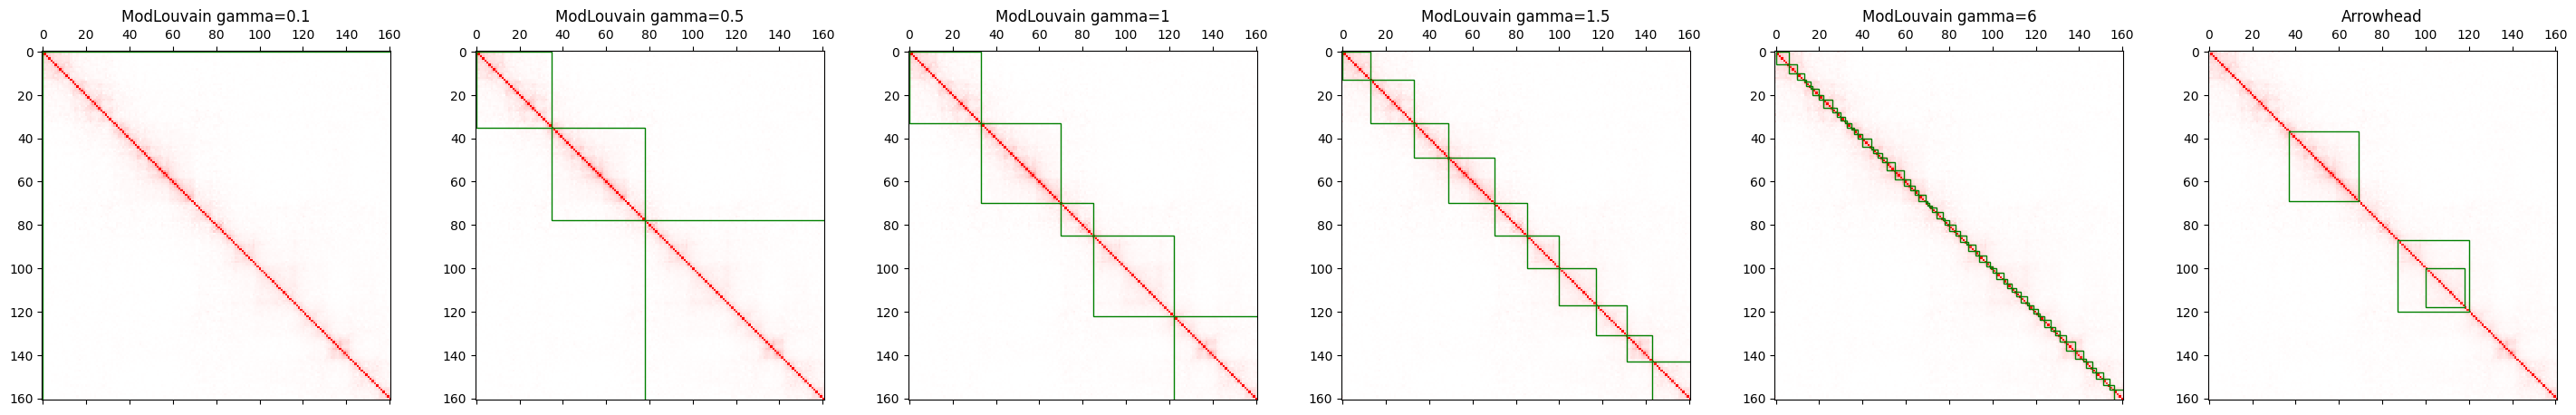

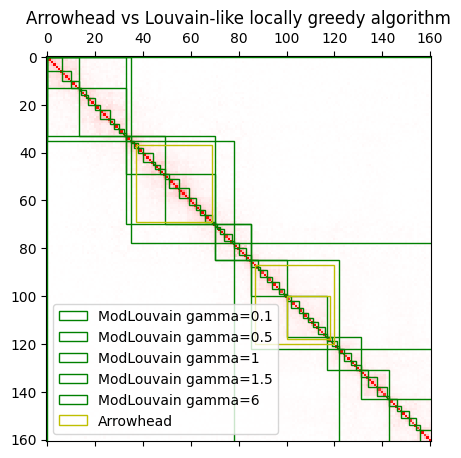

In [10]:
plot_hic_map_compare(
    numpy_matrix,
    numpy_matrix.max() / 2,
    tads=[*communities.values(), arrow_communities],
    titles=[*[f"ModLouvain {gamma=}" for gamma in communities.keys()], "Arrowhead"],
)
plot_hic_map_compare_single(
    numpy_matrix,
    numpy_matrix.max() / 2,
    tads=[*communities.values(), arrow_communities],
    labels=[*[f"ModLouvain {gamma=}" for gamma in communities.keys()], "Arrowhead"],
    colors=[*["g" for _ in range(len(communities))], "y"],
)
plt.title("Arrowhead vs Louvain-like locally greedy algorithm")
plt.show()